# Bicycle Crashes
- Town of Chapel Hill, North Carolina 

In [1]:
import calendar
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys


%matplotlib inline
    
# df = pd.read_csv('https://catalog.data.gov/dataset/bicycle-crashes.csv')
fname = 'https://www.chapelhillopendata.org/api/v2/catalog/datasets/bicycle-crash-data-chapel-hill-region/exports/csv'
df = pd.read_csv(fname, sep=';')




In [2]:
class BikeCrashes:
    def __init__(self, df):
        '''A class to contain and provide analysis for bicycle crashes

        Args:
            df (pd.DataFrame): The dataframe containing the bicycle crashes.

        Returns:
            bool: None
        '''
        self.df = df
        self.testDataFrameForNulls(self.df)
        self.convertDatesToNewColumn('_date', with_time=False)

    def getDataFrame(self):
        '''
        Returns:
            pd.DataFrame: The dataframe contained within the class
        '''
        return self.df

    def testDataFrameForNulls(self, df):
        '''Utility function to test if a dataframe contains any NaNs

        Args:
            df (pd.DataFrame): The variable self.df will be tested for NaNs.

        Exceptions:
            @raise If there are NaNs in the dataframe
        '''
        if 0 != df.isna().values.sum():
            raise Exception("Dataframe contains NaNs")


    def convertDatesToNewColumn(self, new_date_name, with_time=True):
        df = self.df.xs(['crash_year', 'crash_mont', 'crashday', 'crash_time'], axis='columns')
        
        from datetime import datetime, date
        import calendar
        import time
        
        def convertDate(row, with_time):
            if True == with_time:
                crash_time = row['crash_time']
                hour, minute = crash_time.split(':')
                hour = int(hour)
                minute = int(minute)
            else:
                hour = 0
                minute = 0
                                
            # print('hour={} minute={}'.format(hour, minute))
            
            sDate = '{} 1, {} {:02d}:{:02d}'.format(
                row['crash_mont'],
                row['crash_year'],
                hour, minute)
            
            firstOfMonth = datetime.strptime(sDate, "%B %d, %Y %H:%M")
            day_name = row['crashday']

            first = firstOfMonth.weekday()
            requested = 1
            entries = len(calendar.day_name)
            for i in range(entries):
                if day_name == calendar.day_name[(first + requested - 1) % entries]:
                    break
                requested += 1

            str_date = '{:04d}/{:02d}/{:02d} {:02d}:{:02d}'.format(
                firstOfMonth.year,
                firstOfMonth.month,
                requested,
                firstOfMonth.hour,
                firstOfMonth.minute)
            newDate = datetime.strptime(str_date, '%Y/%m/%d %H:%M')
            return newDate
        
        self.df[new_date_name] = [convertDate(row, with_time) for index, row in self.df.iterrows()]

    def showColumns(self):
        print(self.getDataFrame().columns)

    def showSexInjuryVersusSpeedPlots(self, title):
        try:
            # Create a dataframe of the format:
            #                                                                 speed_limit
            # bike_injur          bike_sex                                                   
            # A: Disabling Injury Female                                           [(50, 55)]
            #                     Male               [(40, 45), (30, 35), (40, 45), (30, 35)]
            # B: Evident Injury   Female    [(30, 35), (40, 45), (20, 25), (20, 25), (20, ...
            #                     Male      [(40, 45), (20, 25), (20, 25), (20, 25), (20, ...
            # C: Possible Injury  Female    [(20, 25), (20, 25), (5, 15), (20, 25), (40, 4...
            #                     Male      [(40, 45), (30, 35), (0, 0), (30, 35), (30, 35...
            # K: Killed           Male                         [(20, 25), (50, 55), (40, 45)]
            # O: No Injury        Female                                           [(30, 35)]
            #                     Male      [(30, 35), (20, 25), (20, 25), (20, 25), (40, ...
            # Unknown Injury      Male                                   [(20, 25), (20, 25)]
            #                     Unknown                                          [(30, 35)]
            bike_injur_sex = df.groupby(['bike_injur', 'bike_sex'])
            bike_injur_sex = bike_injur_sex['speed_limit'].apply(list).to_frame()

            injuries = df['bike_injur'].unique()
            sexes = df['bike_sex'].unique()
            dot_prod_injur_sex = pd.MultiIndex.from_product([injuries, sexes], names=['injuries', 'sex'])

            # Create df2 of the form:
            #                 injuries     sex speed_range
            # 0              K: Killed    Male    (20, 25)
            # 1              K: Killed    Male    (50, 55)
            # 2              K: Killed    Male    (40, 45)
            # 3     C: Possible Injury    Male    (40, 45)
            # 4     C: Possible Injury    Male    (30, 35)
            # ..                   ...     ...         ...
            # 160  A: Disabling Injury    Male    (40, 45)
            # 161  A: Disabling Injury    Male    (30, 35)
            # 162  A: Disabling Injury    Male    (40, 45)
            # 163  A: Disabling Injury    Male    (30, 35)
            # 164  A: Disabling Injury  Female    (50, 55)
            # 
            # [165 rows x 5 columns]
            df2 = pd.DataFrame(columns=['injuries', 'sex', 'speed_range'])
            for index in dot_prod_injur_sex:
                try:
                    for speed_range in bike_injur_sex.loc[index]['speed_limit']:
                        df2 = df2.append({
                            'injuries': index[0], 'sex': index[1],
                            'speed_range': speed_range},
                            ignore_index=True)
                except KeyError:
                    pass
                except Exception as e:
                    raise Exception('Error creating dictionary index=', index)

            # Make sure the triplet ['injuries', 'sex', 'speed_range'] is unique and add the # of riders
            #                    injuries      sex speed_range  freq
            # 0   A: Disabling Injury   Female    (50, 55)       1
            # 1   A: Disabling Injury     Male    (30, 35)       2
            # 2   A: Disabling Injury     Male    (40, 45)       2
            # 3     B: Evident Injury   Female      (0, 0)       1
            # 4     B: Evident Injury   Female     (5, 15)       2
            # 5     B: Evident Injury   Female    (20, 25)      10
            # 6     B: Evident Injury   Female    (30, 35)       9
            # 7     B: Evident Injury   Female    (40, 45)       1
            # 8     B: Evident Injury     Male      (0, 0)       2
            # 9     B: Evident Injury     Male     (5, 15)       2
            # 10    B: Evident Injury     Male    (20, 25)      26
            # 11    B: Evident Injury     Male    (30, 35)      15
            # 12    B: Evident Injury     Male    (40, 45)      16
            # 13    B: Evident Injury     Male    (50, 55)       1
            # 14   C: Possible Injury   Female     (5, 15)       1
            # 15   C: Possible Injury   Female    (20, 25)       8
            # 16   C: Possible Injury   Female    (30, 35)       1
            # 17   C: Possible Injury   Female    (40, 45)       2
            # 18   C: Possible Injury     Male      (0, 0)       3
            # 19   C: Possible Injury     Male     (5, 15)       4
            # 20   C: Possible Injury     Male    (20, 25)      17
            # 21   C: Possible Injury     Male    (30, 35)      16
            # 22   C: Possible Injury     Male    (40, 45)      10
            # 23            K: Killed     Male    (20, 25)       1
            # 24            K: Killed     Male    (40, 45)       1
            # 25            K: Killed     Male    (50, 55)       1
            # 26         O: No Injury   Female    (30, 35)       1
            # 27         O: No Injury     Male     (5, 15)       1
            # 28         O: No Injury     Male    (20, 25)       3
            # 29         O: No Injury     Male    (30, 35)       1
            # 30         O: No Injury     Male    (40, 45)       1
            # 31       Unknown Injury     Male    (20, 25)       2
            # 32       Unknown Injury  Unknown    (30, 35)       1
            df2= df2.groupby(['injuries', 'sex', 'speed_range'])['speed_range'].count().reset_index(name="freq")

            # Now pivot the table get the the riders being to only data column
            #                                          freq
            # injuries            sex     speed_range        
            # A: Disabling Injury Female  (50, 55)          1
            #                     Male    (30, 35)          2
            #                             (40, 45)          2
            # B: Evident Injury   Female  (0, 0)            1
            #                             (5, 15)           2
            #                             (20, 25)         10
            #                             (30, 35)          9
            #                             (40, 45)          1
            #                     Male    (0, 0)            2
            #                             (5, 15)           2
            #                             (20, 25)         26
            #                             (30, 35)         15
            #                             (40, 45)         16
            #                             (50, 55)          1
            # C: Possible Injury  Female  (5, 15)           1
            #                             (20, 25)          8
            #                             (30, 35)          1
            #                             (40, 45)          2
            #                     Male    (0, 0)            3
            #                             (5, 15)           4
            #                             (20, 25)         17
            #                             (30, 35)         16
            #                             (40, 45)         10
            # K: Killed           Male    (20, 25)          1
            #                             (40, 45)          1
            #                             (50, 55)          1
            # O: No Injury        Female  (30, 35)          1
            #                     Male    (5, 15)           1
            #                             (20, 25)          3
            #                             (30, 35)          1
            #                             (40, 45)          1
            # Unknown Injury      Male    (20, 25)          2
            #                     Unknown (30, 35)          1
            df3 = pd.pivot_table(df2,index=['injuries', 'sex', 'speed_range'])

            # Calculate the maximum value for X and Y
            x_max = 0
            y_max = 0
            for index in df3.index:
                (injury, sex, speed_range) = index
                if x_max < speed_range[1]:
                    x_max = speed_range[1]

                riders = df3.loc[index]['freq']
                if y_max < riders:
                    y_max = riders

            # Plot the data
            fig, axs = plt.subplots(len(injuries), len(sexes), figsize=(32,32))
            fig.suptitle(title)
            all_injuries_and_sexes = dot_prod_injur_sex
            for index in df3.index:
                (injury, sex, speed_range) = index
                i = np.where(injuries==injury)[0][0]
                s = np.where(sexes==sex)[0][0]

                key = (injury, sex)
                if key in all_injuries_and_sexes:
                    all_injuries_and_sexes = all_injuries_and_sexes.drop([key])

                riders = df3.loc[index]['freq']

                import scipy.stats as stats
                import math

                mu = speed_range[0] + ((speed_range[1] - speed_range[0]) / 2)
                variance = 1
                sigma = math.sqrt(variance)
                x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
                y = stats.norm.pdf(x, mu, sigma)

                axs[i, s].title.set_text('{} | {}'.format(sex, injury))
                axs[i, s].set_xlim([0, x_max])
                axs[i, s].set_ylim([0, y_max])
                axs[i, s].set_xlabel('speed')
                axs[i, s].set_ylabel('freq')

                axs[i, s].fill_between(x, 0, y * 2.5 * riders, color=['r', 'g', 'b'][s])
                #break

            # Turn off subplots that do not contain any data
            for (injury, sex) in all_injuries_and_sexes:
                i = np.where(injuries==injury)[0][0]
                s = np.where(sexes==sex)[0][0]
                axs[i, s].axis('off')

        except Exception as e:
                raise type(e)(str(e)).with_traceback(sys.exc_info()[2])

    def showInjuriesVersusDatePlots(self, resample=None):
        df1 = df.xs(['bike_sex', 'crash_time', '_date'], axis='columns')
        df2 = df1.copy()
        df2['_count'] = 1
        df2.sort_values(by=['_date'], inplace=True)
        df2.set_index('_date')
        #print(df2)
        
        df3 = pd.pivot_table(
            df2, values='_count', index=['_date'], columns=['bike_sex'],
            aggfunc=np.sum, fill_value=0)
        if None != resample:
            df3 = df3.resample(resample).sum()

        #print(df3)

        fig, ax = plt.subplots(figsize=(18,6))
        df3.plot(ax=ax, lw=2)

    def showInjuriesUsingMonthlyOverlay(self):
        df1 = df.xs(['bike_sex', 'crash_time', 'crash_mont'], axis='columns')
        df2 = df1.copy()
        df2['_count'] = 1
        #print(df2)

        df3 = pd.pivot_table(
            df2, values='_count', index=['crash_mont'], columns=['bike_sex'],
            aggfunc=np.sum, fill_value=0)
        df3 = df3.reindex([
            'January', 'February', 'March', 'April', 'May', 'June', 
            'July', 'August', 'September', 'October', 'November', 'December'])
        
        fig, ax = plt.subplots(figsize=(18,6))
        df3.plot(ax=ax, lw=2)
        
    def showInjuriesUsingWeeklyOverlay(self):
        df1 = df.xs(['bike_sex', 'crash_time', 'crashday'], axis='columns')
        df2 = df1.copy()
        df2['_count'] = 1
        #print(df2)

        df3 = pd.pivot_table(
            df2, values='_count', index=['crashday'], columns=['bike_sex'],
            aggfunc=np.sum, fill_value=0)
        df3 = df3.reindex([
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']) 
        
        fig, ax = plt.subplots(figsize=(18,6))
        df3.plot(ax=ax, lw=2)

## Data Preperation

### Create a MultiIndex from a dot-product given a list of two lists

indices = pd.MultiIndex.from_product(
    [['Alice','Bob','Charlie','Dave'], ['cs1', 'cs2']],
    names=['Student', 'Class'])

In [3]:
def translateSpeed(speed):
    ''' Utility function to translate a min/max speed into a tuple  "25 - 35 MPH" to (25, 35)

    Todo:
        Make this function more generic

    Args:
        speed (str) : The speed range in the format "25 - 35 MPH"
    '''

    m = re.findall(r'^(\d+)\s*-\s*(\d+)\s*MPH$', speed)
    if m:
        m = (np.uint32(m[0][0]), np.uint32(m[0][1]))
    else:
        m = (0,0)

    #print("translateSpeed({}) = {}".format(x, m))
    return m

try:

    # Create a dataframe with the following format:
    #                                                                     speed_limit
    # bike_injur          bike_sex                                                   
    # A: Disabling Injury Female                                           [(50, 55)]
    #                     Male               [(40, 45), (30, 35), (40, 45), (30, 35)]
    # B: Evident Injury   Female    [(30, 35), (40, 45), (20, 25), (20, 25), (20, ...
    #                     Male      [(40, 45), (20, 25), (20, 25), (20, 25), (20, ...
    # C: Possible Injury  Female    [(20, 25), (20, 25), (5, 15), (20, 25), (40, 4...
    #                     Male      [(40, 45), (30, 35), (0, 0), (30, 35), (30, 35...
    # K: Killed           Male                         [(20, 25), (50, 55), (40, 45)]
    # O: No Injury        Female                                           [(30, 35)]
    #                     Male      [(30, 35), (20, 25), (20, 25), (20, 25), (40, ...
    # Unknown Injury      Male                                   [(20, 25), (20, 25)]
    #                     Unknown                                          [(30, 35)]
    df['speed_limit'] = [translateSpeed(x) for i, x in enumerate(df['speed_limi'])]

except Exception as e:
        raise type(e)(str(e)).with_traceback(sys.exc_info()[2])

In [4]:

bikeCrashes = BikeCrashes(df)
#bikeCrashes.getDataFrame().head()


In [5]:
bikeCrashes.showColumns()

Index(['geo_point_2d', 'geo_shape', 'ambulancer', 'bikeage_gr', 'bike_age',
       'bike_dir', 'bike_injur', 'bike_pos', 'bike_race', 'bike_sex', 'city',
       'county', 'crashalcoh', 'crashday', 'crash_grp', 'crash_loc',
       'crash_mont', 'crash_time', 'crash_type', 'crash_year', 'crsh_sevri',
       'developmen', 'drvrage_gr', 'drvr_age', 'drvr_alc_d', 'drvr_estsp',
       'drvr_injur', 'drvr_race', 'drvr_sex', 'drvr_vehty', 'excsspdind',
       'hit_run', 'light_cond', 'locality', 'num_lanes', 'num_units',
       'rd_charact', 'rd_class', 'rd_conditi', 'rd_config', 'rd_defects',
       'rd_feature', 'rd_surface', 'rural_urba', 'speed_limi', 'traff_cntr',
       'weather', 'workzone_i', 'speed_limit', '_date'],
      dtype='object')


In [6]:
#bikeCrashes.showSexInjuryVersusSpeedPlots('Bicycle Crashes - Town of Chapel Hill, North Carolina')

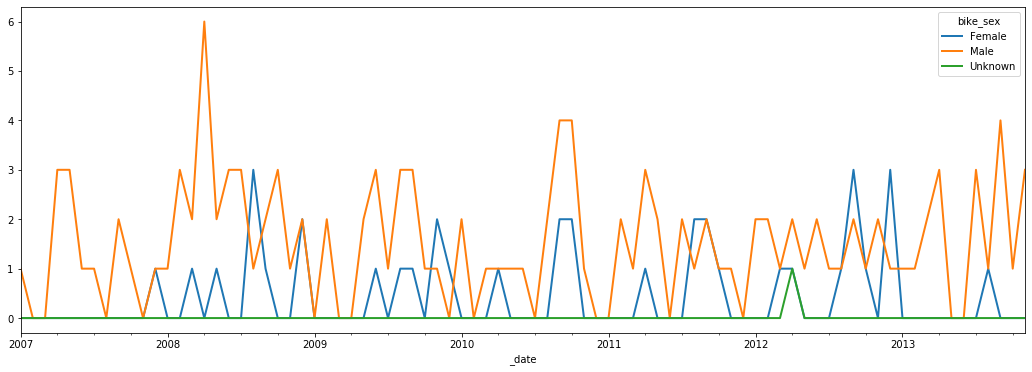

In [7]:
bikeCrashes.showInjuriesVersusDatePlots(resample='M')


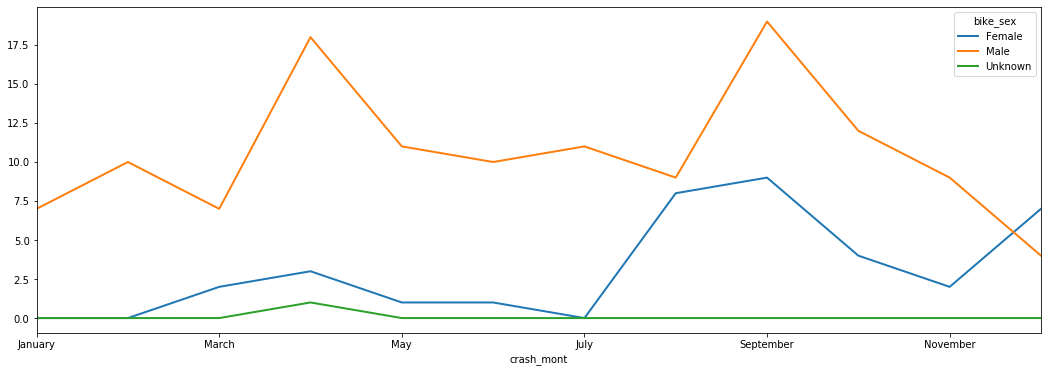

In [8]:
bikeCrashes.showInjuriesUsingMonthlyOverlay()


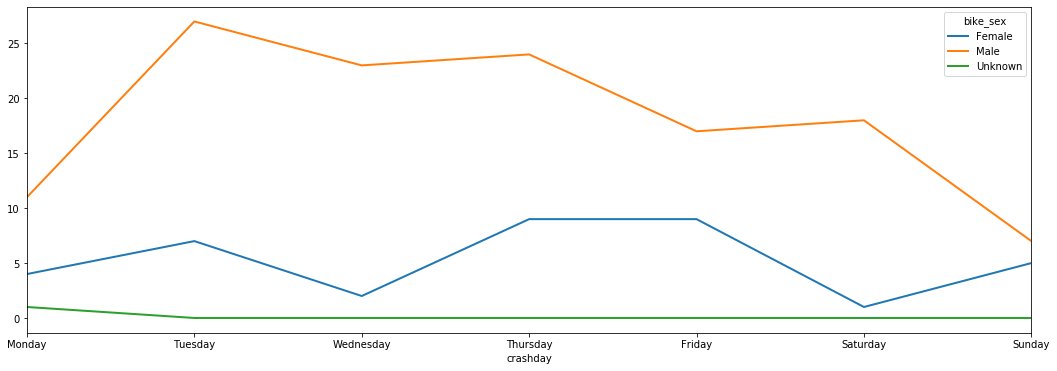

In [9]:
bikeCrashes.showInjuriesUsingWeeklyOverlay()

In [10]:
%tb


No traceback available to show.
